In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer
import numpy as np

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


### Masked flux- / flux+ 


In [2]:
def get_explanations(model, loader):
    
    explainer    = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
    model.to(device, non_blocking=True)


    model.eval()
    gc.collect()
    torch.cuda.empty_cache() 
    edge_num           = loader.dataset[0].edge_index.shape[1]
    all_graphs_weights = []#torch.empty(edge_num,1).to(device)

    for graph in loader.dataset[0:500]:
        _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
        
        all_graphs_weights.append(edge_weights.reshape(edge_num,1))
        
        
        

    return pd.DataFrame(
                        torch.stack(all_graphs_weights,1).squeeze().cpu().numpy().astype(float))
    
                                
model_masked_FLUX   = torch.load("./results/trained_models/Flux/Masked/GIN/Model_GIN_05-12-2022_15h_56min_best_ValAcc_0.9041932796445432_epoch_18.pt")
loader_masked_FLUX  = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_test_loader()
masked_FLUX = get_explanations(model_masked_FLUX, loader_masked_FLUX)
                                    
model_masked_NONflux   = torch.load("./results/trained_models/Non_flux/Masked/GIN/Model_GIN_05-12-2022_15h_53min_best_ValAcc_0.8597611774507081_epoch_18.pt")
loader_masked_NONflux  = torch.load("./results/dataloaders/MASKED_loader_only_Concen.pt").get_test_loader()
masked_NONflux = get_explanations(model_masked_NONflux, loader_masked_NONflux)

Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 768.70it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

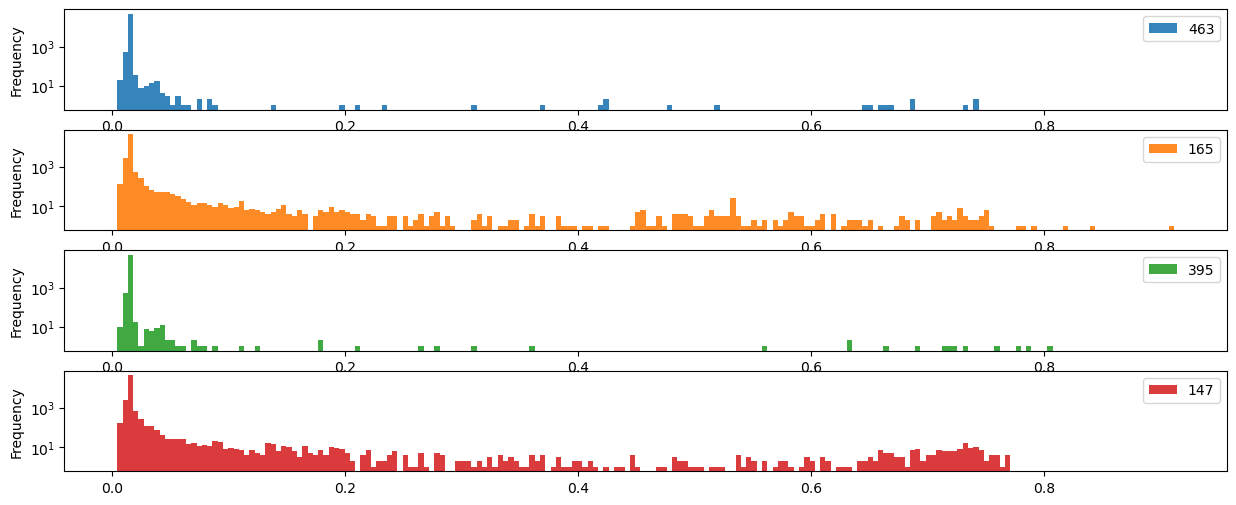

In [3]:
masked_FLUX.loc[:,np.random.randint(0, masked_FLUX.columns.__len__(), 4 )].select_dtypes(float).plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, grid=False)


In [4]:
def get_df_labels_and_colnames(all_graphs_weights_df, loader, path_to_save_labels, path_PYG_graph, path_NX_graph):
    
    train_labels = []
    for graph in tqdm.tqdm(loader.dataset[0:500]):
        train_labels.append(graph.y.cpu().item())
    assert train_labels.__len__() == all_graphs_weights_df.shape[1]
    #all_graphs_weights.shape

    labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
    
    pd.Series(labels).to_csv(path_to_save_labels)

    all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]
    print(f"{all_graphs_weights_df.shape=}")
    
    
    
    edge_mask = all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 99)


    filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]  
    filtered_graph_weights    = filtered_graph_weights_df.transpose() 
    filtered_graph_weights["Label"] = list(labels)
    filtered_graph_weights.reset_index(drop=True, inplace=True)
    filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
       

    PYG_graph = torch.load(path_PYG_graph)
    NX_graph  = nx.read_gpickle(path_NX_graph)
    edge_0_node_idxs =  PYG_graph.edge_index[0,:]
    edge_1_node_idxs =  PYG_graph.edge_index[1,:]
    edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
    edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
    edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
    edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]
    

    return edges_node_names_explainer_subgraphs
 

explanatory_subgraph_masked_FLUX = get_df_labels_and_colnames(masked_FLUX, loader_masked_FLUX, 
                                                                  path_to_save_labels = "./results/dataframes/test_labels_masked_FLUX.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_Concen_plus_Fluxes.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")


explanatory_subgraph_masked_NONflux = get_df_labels_and_colnames(masked_NONflux, loader_masked_NONflux, 
                                                                  path_to_save_labels = "./results/dataframes/test_labels_masked_NONflux.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_Concen_plus_Fluxes.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")



100%|██████████| 500/500 [00:00<00:00, 274173.36it/s]


all_graphs_weights_df.shape=(50442, 500)


100%|██████████| 500/500 [00:00<00:00, 374893.10it/s]


all_graphs_weights_df.shape=(50442, 500)


In [5]:
explanatory_subgraph_masked_NONflux

,node1,node2,0,1,2,3,4,5,6,7,...,490,491,492,493,494,495,496,497,498,499
9125,val_L_c,r1659,0.013759,0.663229,0.072295,0.794343,0.157651,0.047477,0.718332,0.013996,...,0.192231,0.207602,0.063182,0.169742,0.013927,0.953045,0.013849,0.748983,0.320102,0.013883
9128,val_L_c,r1909,0.013864,0.685872,0.075776,0.803910,0.169142,0.049186,0.735130,0.013940,...,0.202378,0.225891,0.065112,0.179841,0.013858,0.954067,0.013894,0.764703,0.348414,0.013852
9150,val_L_c,r1644,0.013881,0.650760,0.070430,0.790413,0.150546,0.046621,0.711348,0.013730,...,0.186878,0.198251,0.062032,0.165233,0.013934,0.953053,0.013803,0.734956,0.311358,0.013822
9160,val_L_c,r1818,0.013880,0.713899,0.082118,0.816506,0.191687,0.052090,0.760997,0.013823,...,0.222079,0.261006,0.068843,0.195526,0.013936,0.955612,0.013781,0.791553,0.393312,0.013668
9169,val_L_c,r1861,0.013794,0.686421,0.076701,0.806278,0.172001,0.049553,0.739204,0.013863,...,0.206394,0.233031,0.065668,0.182333,0.013982,0.954286,0.013862,0.770544,0.357550,0.013841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36261,orn_c,r2404,0.013781,0.913564,0.030811,0.907537,0.906212,0.915990,0.896181,0.013796,...,0.795431,0.904643,0.794685,0.786874,0.013979,0.037245,0.013769,0.034506,0.905911,0.013850
36262,orn_c,r2405,0.013649,0.816948,0.023292,0.824100,0.023622,0.858237,0.699381,0.013760,...,0.374301,0.029454,0.412794,0.374083,0.013877,0.032361,0.013920,0.034861,0.800937,0.013688
36263,orn_c,r2412,0.013722,0.887993,0.029476,0.884063,0.870380,0.898668,0.851316,0.013799,...,0.666100,0.858194,0.681195,0.657556,0.013824,0.032955,0.013842,0.034173,0.878155,0.013877
36264,orn_c,ORNLEUrBATtc,0.013890,0.850336,0.014768,0.851277,0.804333,0.875825,0.774388,0.013939,...,0.489275,0.754971,0.516924,0.486308,0.013869,0.048107,0.013824,0.204582,0.842319,0.013805


In [6]:
explanatory_subgraph_masked_FLUX

,node1,node2,0,1,2,3,4,5,6,7,...,490,491,492,493,494,495,496,497,498,499
8670,CSNATr,acrn_c,0.012148,0.013416,0.011276,0.011888,0.096076,0.166618,0.011295,0.012245,...,0.011613,0.184368,0.011355,0.011329,0.011254,0.016307,0.010661,0.011843,0.169054,0.049353
9125,val_L_c,r1659,0.014589,0.031423,0.030059,0.013978,0.803187,0.790388,0.033168,0.015119,...,0.021375,0.674615,0.038831,0.025976,0.020469,0.037111,0.023664,0.015999,0.792715,0.311713
9126,val_L_c,r1758,0.019427,0.024003,0.023445,0.017814,0.663541,0.725609,0.024899,0.016226,...,0.025530,0.446894,0.026860,0.021713,0.030820,0.460138,0.021926,0.019105,0.675851,0.360610
9128,val_L_c,r1909,0.025714,0.185707,0.041876,0.021220,0.804908,0.761306,0.377098,0.018102,...,0.402875,0.700829,0.710925,0.036056,0.903131,0.751229,0.078465,0.025082,0.797127,0.649089
9133,val_L_c,r1554,0.011886,0.011325,0.011246,0.012258,0.095098,0.124077,0.011395,0.012790,...,0.011012,0.091430,0.011054,0.011610,0.010834,0.074922,0.011403,0.012053,0.105984,0.084411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49122,asp_L_c,ASPLYSGLUr,0.015080,0.014520,0.016201,0.014632,0.046056,0.200517,0.014466,0.014775,...,0.014014,0.037121,0.014496,0.015919,0.013781,0.107351,0.014789,0.015994,0.206875,0.041607
49124,asp_L_c,TYRASPARGr,0.013919,0.013840,0.013825,0.013828,0.013604,0.212942,0.013892,0.013767,...,0.013835,0.041500,0.013743,0.013781,0.013930,0.165055,0.013726,0.013870,0.270971,0.013575
49126,asp_L_c,ASPTA,0.015542,0.014595,0.015240,0.014744,0.039506,0.121339,0.014347,0.014691,...,0.014592,0.031746,0.015140,0.015525,0.014958,0.058102,0.015294,0.015355,0.184396,0.023219
49128,asp_L_c,ASPGLUm,0.015708,0.014714,0.018214,0.014832,0.065192,0.228103,0.014527,0.014792,...,0.015061,0.046203,0.016832,0.015949,0.015475,0.085914,0.015675,0.016054,0.374638,0.053085


In [8]:
explanatory_subgraph_masked_FLUX.to_parquet(
    "./results/dataframes/explanatory_subgraph_masked_FLUX.parquet.gzip", compression='gzip')
explanatory_subgraph_masked_NONflux.to_parquet(
    "./results/dataframes/explanatory_subgraph_masked_NONflux.parquet.gzip", compression='gzip')

### Process explainer weights

((505, 2), (50442,))

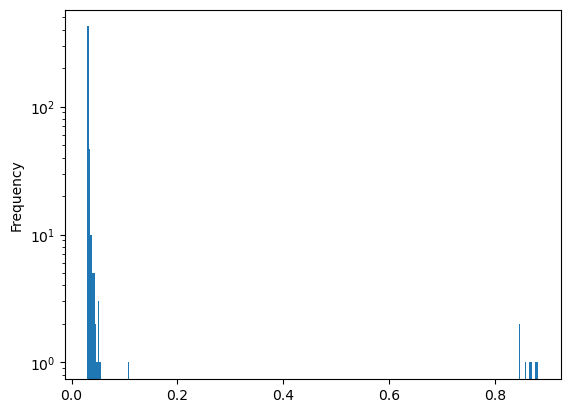

In [18]:
#edge_mask = all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 99)
#filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]

filtered_graph_weights_df.sum(axis=1).plot.hist(logy = True, bins=300)
filtered_graph_weights_df.shape, edge_mask.shape


<AxesSubplot:ylabel='Frequency'>

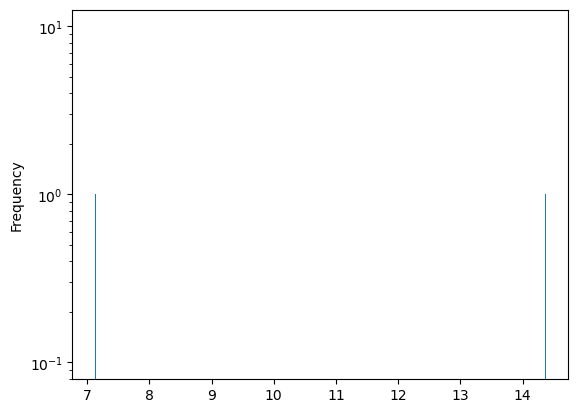

In [19]:
filtered_graph_weights_df.sum(axis=0).plot.hist(logy = True, bins=500)


In [24]:
filtered_graph_weights = filtered_graph_weights_df.transpose() 
filtered_graph_weights["Label"] = list(labels)

filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights

,60,116,117,354,703,706,726,736,793,1017,...,49793,49794,49911,50062,50063,50105,50185,50350,50359,Label
0,0.014967,0.015270,0.014483,0.013181,0.012910,0.012549,0.012754,0.013034,0.012704,0.013035,...,0.014735,0.014004,0.013066,0.012559,0.012621,0.012556,0.012489,0.012889,0.012935,PKU
1,0.014388,0.022956,0.015676,0.016316,0.016337,0.017246,0.016619,0.017019,0.017145,0.016187,...,0.014570,0.015502,0.016519,0.018073,0.017381,0.017218,0.017030,0.016586,0.016495,PKU


In [12]:
PYG_graph = torch.load("./results/graphs/PYG_graph_Concen_plus_Fluxes.pt")
NX_graph  = nx.read_gpickle("./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")
edge_0_node_idxs =  PYG_graph.edge_index[0,:]
edge_1_node_idxs =  PYG_graph.edge_index[1,:]
edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]

edges_node_names_explainer_subgraphs

,node1,node2,0,1
60,TRPGLULEUr,glu_L_c,0.014967,0.014388
116,C160CPT1,coa_c,0.015270,0.022956
117,C160CPT1,crn_c,0.014483,0.015676
354,CYTK10,cdp_c,0.013181,0.016316
703,r1758,trp_L_c,0.012910,0.016337
...,...,...,...,...
50063,L_LACt4r,lac_L_e,0.012621,0.017381
50105,CYTK5,dcmp_c,0.012556,0.017218
50185,AHCYStr,ahcys_r,0.012489,0.017030
50350,DOPAt4_2_r,dopa_c,0.012889,0.016586


In [14]:

edges_node_names_explainer_subgraphs.to_parquet(
    "./results/dataframes/Masked_edges_node_names_explainer_subgraphs.parquet.gzip", compression='gzip')